In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL
#
import cv2
import glob
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os

### Use Keras Model Architecture 

In [2]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers
from keras.optimizers import SGD
import tensorflow as tf

Using TensorFlow backend.


### Dataset Preparation 

In [3]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [4]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [5]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [6]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [7]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [8]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [9]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [10]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [11]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [12]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

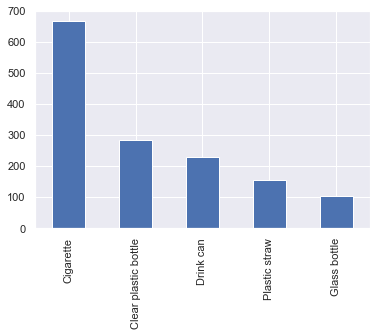

In [13]:
df['category'].value_counts().plot.bar()

### Fetch, crop and store image data

In [14]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

In [15]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

In [16]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)

In [17]:
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


In [18]:
df1 = pd.get_dummies(df, columns=["category"])
df1.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Glass bottle,category_Plastic straw
0,batch_1/000006.jpg,0,0,0,1,0
1,batch_1/000012.jpg,0,0,0,1,0
2,batch_1/000048.jpg,0,0,0,1,0
3,batch_1/000021.jpg,0,0,0,1,0
4,batch_1/000022.jpg,0,0,0,1,0


In [19]:
# 
y = np.array(df1.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1442, 5)
(1442, 128, 128, 3)


### Data Split 

In [20]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Build Keras Model 

In [21]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [22]:
#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)       

In [23]:
#Optimizer used in the models
opt = SGD(lr=0.01, momentum=0.9)

## Keras Model Implementation Using 'Accuracy' Method

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Model fit
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=30)

Train on 1153 samples, validate on 289 samples
Epoch 1/200
1153/1153 [==============================] - 28s 25ms/step - loss: 11.0257 - accuracy: 0.3382 - val_loss: 1.5536 - val_accuracy: 0.4879
Epoch 2/200
1153/1153 [==============================] - 24s 21ms/step - loss: 1.5216 - accuracy: 0.4441 - val_loss: 1.4698 - val_accuracy: 0.4879
Epoch 3/200
1153/1153 [==============================] - 24s 21ms/step - loss: 1.4621 - accuracy: 0.4562 - val_loss: 1.4115 - val_accuracy: 0.4879
Epoch 4/200
1153/1153 [==============================] - 24s 21ms/step - loss: 1.4366 - accuracy: 0.4571 - val_loss: 1.3872 - val_accuracy: 0.4879
Epoch 5/200
1153/1153 [==============================] - 24s 21ms/step - loss: 1.4296 - accuracy: 0.4562 - val_loss: 1.3779 - val_accuracy: 0.4879
Epoch 6/200
1153/1153 [==============================] - 24s 21ms/step - loss: 1.4182 - accuracy: 0.4562 - val_loss: 1.3743 - val_accuracy: 0.4879
Epoch 7/200
1153/1153 [==============================] - 24s 21ms/step

1153/1153 [==============================] - 24s 21ms/step - loss: 0.9523 - accuracy: 0.6210 - val_loss: 0.9800 - val_accuracy: 0.6159
Epoch 57/200
1153/1153 [==============================] - 25s 22ms/step - loss: 0.9352 - accuracy: 0.6435 - val_loss: 0.9503 - val_accuracy: 0.6298
Epoch 58/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.9299 - accuracy: 0.6583 - val_loss: 0.9096 - val_accuracy: 0.6609
Epoch 59/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.9377 - accuracy: 0.6453 - val_loss: 0.9030 - val_accuracy: 0.6505
Epoch 60/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.9080 - accuracy: 0.6375 - val_loss: 0.8645 - val_accuracy: 0.6574
Epoch 61/200
1153/1153 [==============================] - 25s 22ms/step - loss: 0.9087 - accuracy: 0.6409 - val_loss: 1.0353 - val_accuracy: 0.6055
Epoch 62/200
1153/1153 [==============================] - 25s 22ms/step - loss: 0.9448 - accuracy: 0.6383 - val_loss: 0.9031 

1153/1153 [==============================] - 25s 22ms/step - loss: 0.6988 - accuracy: 0.7337 - val_loss: 1.0142 - val_accuracy: 0.6471
Epoch 112/200
1153/1153 [==============================] - 27s 23ms/step - loss: 0.7255 - accuracy: 0.7285 - val_loss: 0.9997 - val_accuracy: 0.6505
Epoch 113/200
1153/1153 [==============================] - 25s 22ms/step - loss: 0.7087 - accuracy: 0.7242 - val_loss: 0.9547 - val_accuracy: 0.6436
Epoch 114/200
1153/1153 [==============================] - 25s 22ms/step - loss: 0.7126 - accuracy: 0.7251 - val_loss: 1.0272 - val_accuracy: 0.6367
Epoch 115/200
1153/1153 [==============================] - 23s 20ms/step - loss: 0.6676 - accuracy: 0.7493 - val_loss: 1.0493 - val_accuracy: 0.6367
Epoch 116/200
1153/1153 [==============================] - 23s 20ms/step - loss: 0.7020 - accuracy: 0.7251 - val_loss: 1.2635 - val_accuracy: 0.6367
Epoch 117/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.7244 - accuracy: 0.7337 - val_loss: 1

1153/1153 [==============================] - 24s 21ms/step - loss: 0.4281 - accuracy: 0.8517 - val_loss: 1.5990 - val_accuracy: 0.6609
Epoch 167/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.4275 - accuracy: 0.8569 - val_loss: 1.3740 - val_accuracy: 0.6609
Epoch 168/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.4040 - accuracy: 0.8604 - val_loss: 1.4945 - val_accuracy: 0.6713
Epoch 169/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.3970 - accuracy: 0.8630 - val_loss: 1.7793 - val_accuracy: 0.6263
Epoch 170/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.3967 - accuracy: 0.8682 - val_loss: 1.8792 - val_accuracy: 0.6332
Epoch 171/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.4392 - accuracy: 0.8456 - val_loss: 1.5496 - val_accuracy: 0.6401
Epoch 172/200
1153/1153 [==============================] - 24s 21ms/step - loss: 0.4773 - accuracy: 0.8335 - val_loss: 1

### Model Evaluation 

In [26]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

289/289 [==============================] - 2s 6ms/step
Train: 0.948, Test: 0.675


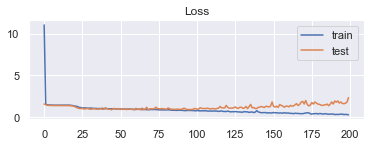

In [27]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

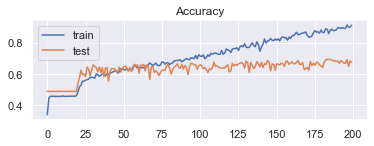

In [28]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## Keras Model Implementation Using 'MSE' Method

In [77]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])

In [78]:
# Model fit
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=30)

Train on 1412 samples, validate on 353 samples
Epoch 1/200
1412/1412 [==============================] - 65s 46ms/step - loss: 0.1335 - mse: 0.1204 - val_loss: 0.1909 - val_mse: 0.1840
Epoch 2/200
1412/1412 [==============================] - 61s 43ms/step - loss: 0.1626 - mse: 0.1566 - val_loss: 0.1836 - val_mse: 0.1748
Epoch 3/200
1412/1412 [==============================] - 49s 34ms/step - loss: 0.1493 - mse: 0.1435 - val_loss: 0.1773 - val_mse: 0.1720
Epoch 4/200
1412/1412 [==============================] - 47s 33ms/step - loss: 0.1399 - mse: 0.1308 - val_loss: 0.1889 - val_mse: 0.1815
Epoch 5/200
1412/1412 [==============================] - 53s 38ms/step - loss: 0.1127 - mse: 0.1062 - val_loss: 0.1706 - val_mse: 0.1630
Epoch 6/200
1412/1412 [==============================] - 46s 33ms/step - loss: 0.1339 - mse: 0.1242 - val_loss: 0.2039 - val_mse: 0.1978
Epoch 7/200
1412/1412 [==============================] - 46s 32ms/step - loss: 0.1137 - mse: 0.1077 - val_loss: 0.1741 - val_mse: 0

1412/1412 [==============================] - 37s 26ms/step - loss: 0.0397 - mse: 0.0376 - val_loss: 0.1558 - val_mse: 0.1523
Epoch 61/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0391 - mse: 0.0364 - val_loss: 0.1708 - val_mse: 0.1675
Epoch 62/200
1412/1412 [==============================] - 38s 27ms/step - loss: 0.0493 - mse: 0.0465 - val_loss: 0.1554 - val_mse: 0.1513
Epoch 63/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0451 - mse: 0.0423 - val_loss: 0.1601 - val_mse: 0.1553
Epoch 64/200
1412/1412 [==============================] - 40s 28ms/step - loss: 0.0324 - mse: 0.0300 - val_loss: 0.1689 - val_mse: 0.1648
Epoch 65/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0308 - mse: 0.0289 - val_loss: 0.1591 - val_mse: 0.1554
Epoch 66/200
1412/1412 [==============================] - 36s 25ms/step - loss: 0.0254 - mse: 0.0238 - val_loss: 0.1547 - val_mse: 0.1516
Epoch 67/200
1412/1412 [=======================

Epoch 178/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0292 - mse: 0.0280 - val_loss: 0.1773 - val_mse: 0.1754
Epoch 179/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0549 - mse: 0.0535 - val_loss: 0.1560 - val_mse: 0.1525
Epoch 180/200
1412/1412 [==============================] - 89s 63ms/step - loss: 0.0737 - mse: 0.0715 - val_loss: 0.1834 - val_mse: 0.1802
Epoch 181/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0436 - mse: 0.0418 - val_loss: 0.1686 - val_mse: 0.1658
Epoch 182/200
1412/1412 [==============================] - 91s 65ms/step - loss: 0.0240 - mse: 0.0232 - val_loss: 0.1656 - val_mse: 0.1633
Epoch 183/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0256 - mse: 0.0245 - val_loss: 0.1783 - val_mse: 0.1754
Epoch 184/200
1412/1412 [==============================] - 94s 67ms/step - loss: 0.0428 - mse: 0.0411 - val_loss: 0.1750 - val_mse: 0.1730
Epoch 185/200
1412/1412 [==

In [79]:
# evaluate the model
_, train_mse = model.evaluate(X_train, y_train)
_, test_mse = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

353/353 [==============================] - 4s 12ms/step
Train: 0.023, Test: 0.157


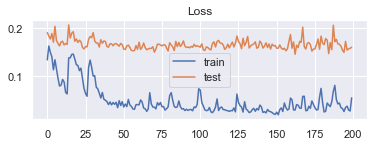

In [80]:
# plot loss during training
pyplot.subplot(411)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

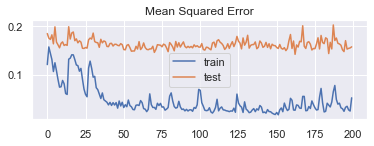

In [82]:
# plot mse during training
pyplot.subplot(412)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='test')
pyplot.legend()
pyplot.show()